# Imports and utility functions

In [1]:
import numpy as np
import time, glob, gc, os, sys, re
import pandas as pd
import seaborn as sns
import tifffile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import tpae.data.ingest as ti

data_dir = '../uc-data'
raw_dir = f'{data_dir}/raw'
out_dir = f'{data_dir}/10u'
metadata = pd.read_csv(f'{data_dir}/UC_Project_Metadata_Truncated.csv')
os.makedirs(f'{raw_dir}', exist_ok=True)
os.makedirs(f'{out_dir}', exist_ok=True)

pixelsize = 0.75488 # in microns
downsample_factor = int(10//pixelsize)

k = 10
repname = f'pca_k={k}_harmony'

# read in channel names and files 
channel_names_filepath = f'{data_dir}/channelNames.txt'
with open(channel_names_filepath, 'r') as file: 
    markers = file.read().splitlines()

files = glob.glob(f"{data_dir}/raw/run[1-36-8]/*.tif")

# Read raw data and downsample

In [8]:
# convert all files to xarray

for file in files:     
    da = tifffile.TiffFile(file)
    da = da.asarray().astype('uint16')
    da = np.reshape(da, newshape = (-1, da.shape[2], da.shape[3])).transpose(1, 2, 0)
    da = ti.downsample(da, factor = downsample_factor)
    
    run = os.path.basename(os.path.dirname(file))
    file = os.path.basename(re.sub("00", "", file.split("_")[0]))
    file = f"{run}{file}"
    sample_id = metadata.loc[metadata['Run Info'] == file, :]
    
    if sample_id.shape[0] == 1: 
        sid = sample_id['Patient ID# for manuscript'].values[0] 
        donor_id = sample_id['Patient.ID'].values[0]
        da = xr.DataArray(da, 
                          dims = ("y", "x", "marker"), 
                          coords = {"y": np.arange(da.shape[0], dtype = np.float32),
                                    "x": np.arange(da.shape[1], dtype = np.float32),
                                    'marker': markers}, 
                          attrs = {"name": sid, 
                                   "donor": donor_id}, 
                          name = sid) 
        da.to_netcdf(f"{out_dir}/{sid}.nc", 
                                  format = "NETCDF4", 
                                  encoding = {da.name: {'zlib': True, 'complevel': 2}})
        print(f"{sid} done")

UC29 done
UC28 done
UC11 done
UC3 done
UC8 done
UC1 done
UC2a done
UC2b done
UC15 done
UC26 done
UC9 done
UC10 done
UC21 done
UC4a done
UC4b done
UC4c done
UC7 done
UC14a done
UC14b done
UC17 done
UC25 done
HC2b done
HC2a done
HC1 done
HC5 done
HC4 done
HC3 done
UC13b done
UC5 done
UC6 done
UC27 done
UC16a done
UC16b done
UC13a done
UC19 done
UC12 done
UC23b done
UC23a done
UC20 done
UC24 done
UC22 done


**note:** 349 x 362 is smaller than other datasets we've looked at, just fyi. No action item

# Visual sanity checks

In [2]:
# read in data
samples = [
    xr.open_dataset(f, engine='netcdf4')
    for f in glob.glob(f"{out_dir}/*.nc")
]

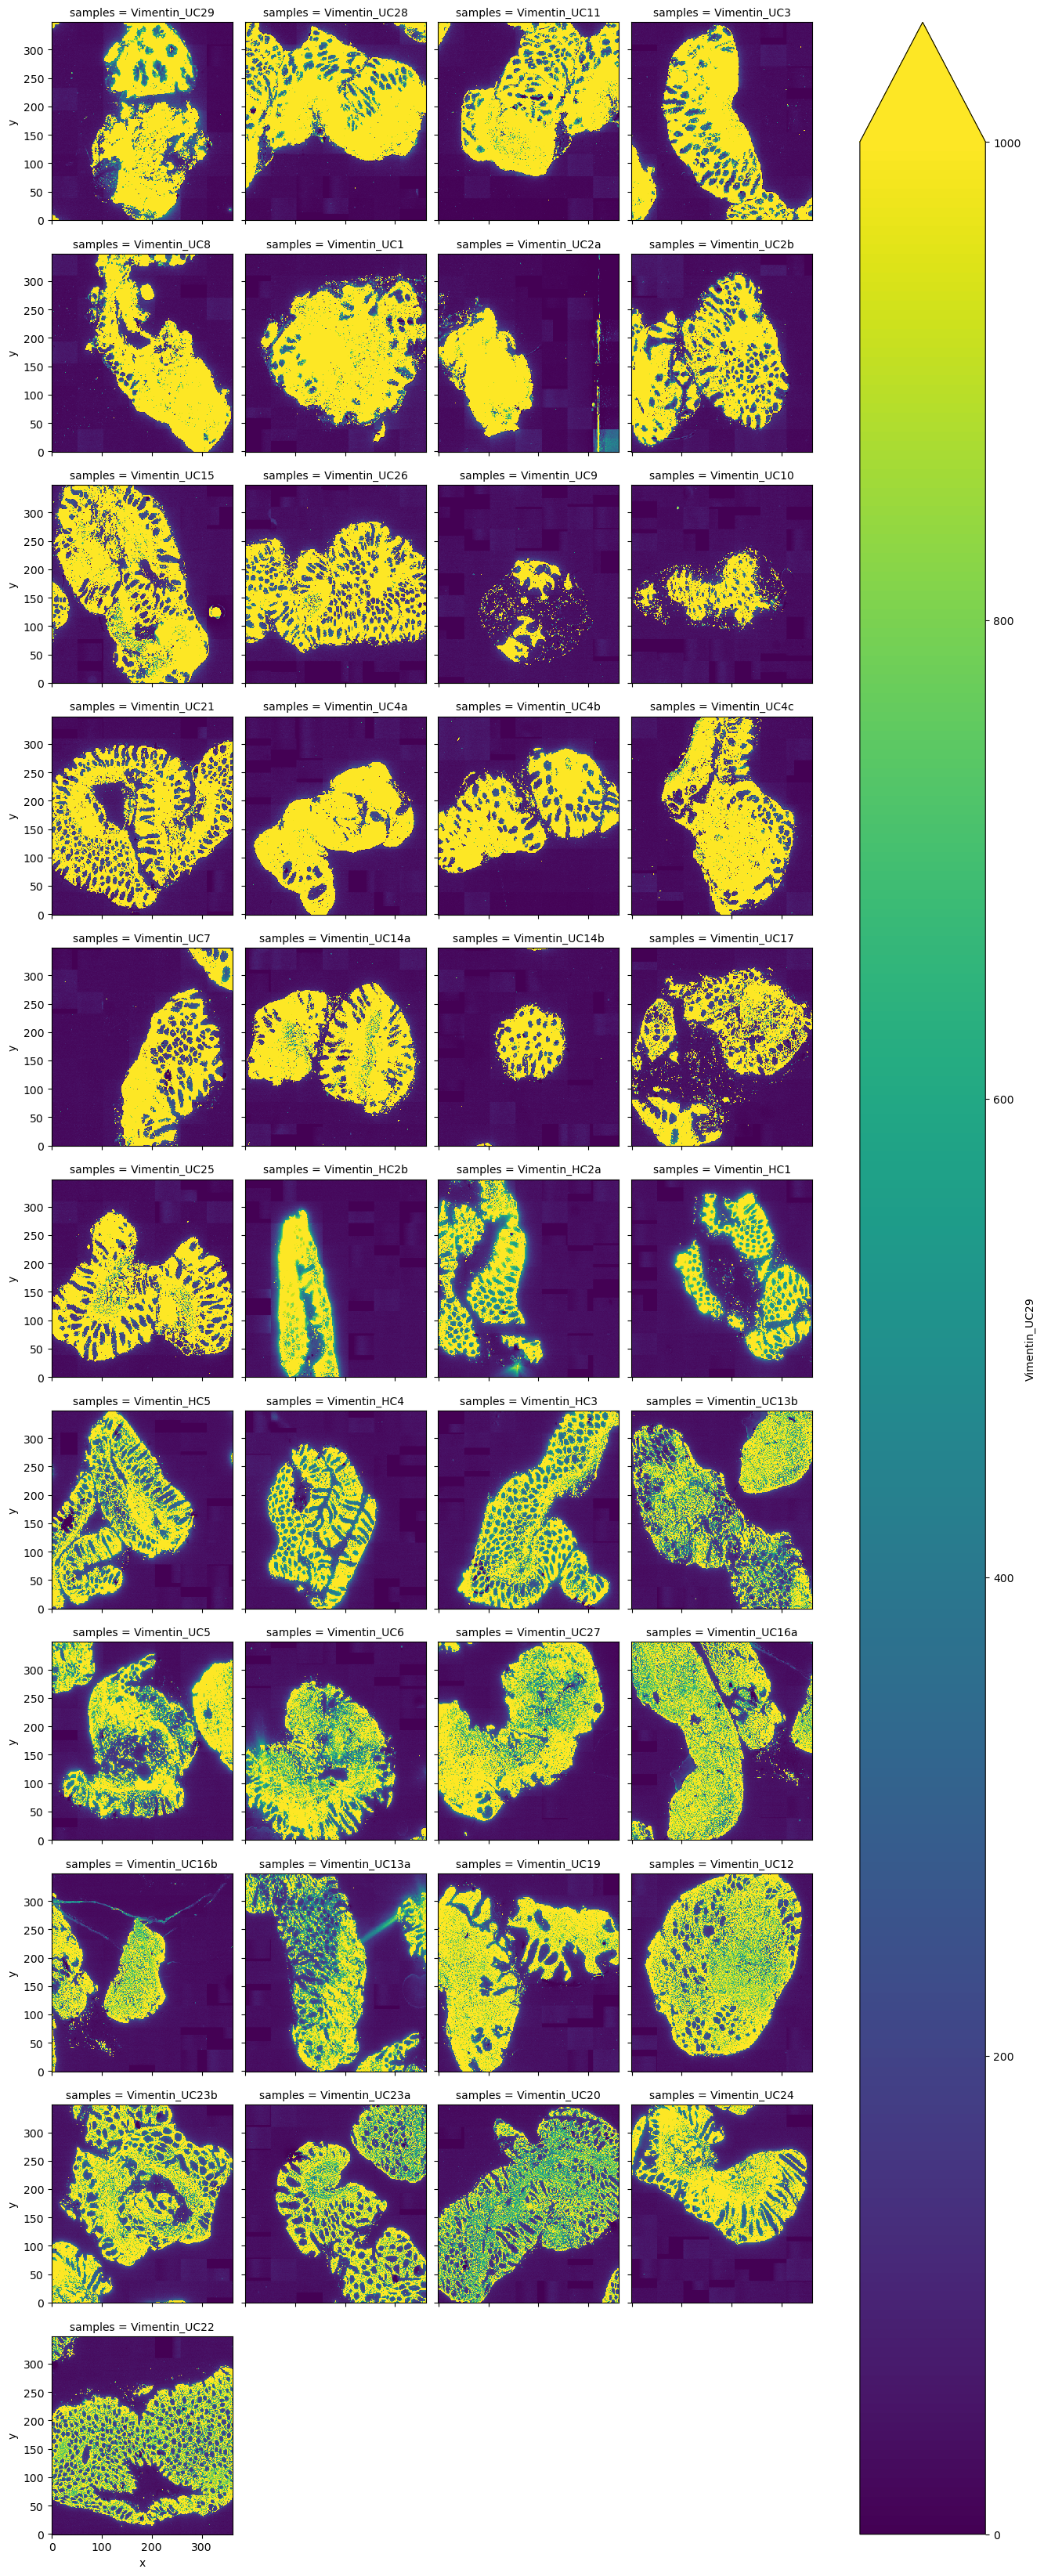

In [6]:
def extract_marker(s, stain): 
    sid = list(s.data_vars)[0]
    res = s[sid].sel(marker=stain).rename(f"{stain}_{sid}")
    res = res.rename({"marker": "samples"}).assign_coords({"samples": f"{stain}_{sid}"})
    return(res)

vimentin = xr.concat([
    extract_marker(s, "Vimentin") for s in samples
], dim = 'samples')

vimentin.plot(col='samples', col_wrap = 4, vmax = 1000)

# to-do

For prior code:
1) make sure all the random "code" I wrote actually runs
1) read in sample metadata file so you can assign sid's based on last column there
1) modify downsampling code to add 'sid' and 'donor' to s.attrs as well sid to s.name, and saves to f'{data_dir}/10u/counts' (with compression={'zlib': True, 'complevel': 2} and filename of {sid}.nc)
1) modify downsampling code so all files are saved in one flat directory
1) convince yourself 100% that marker names are in the correct order relative to the xarrays. (look at blanks, google image "vimentin pathology slide", look at the nuclear stains)

For future:
1) adapt code in scratch to determine tissue mask and produce an image with total intensity in red and foreground mask overlaid in white (with alpha=0.5) for all samples. can steal plotting code from ti.write_masks.
2) think about how to make foreground mask as well as possible

# Identify foreground

# scratch

In [29]:
# or could play around more with this code if needing control over more details
import cv2 as cv2 

run = os.path.basename(os.path.dirname(files[0]))
filename = os.path.basename(files[0])
sample = xr.open_dataset(f"/data/srlab1/lakshay-yakir/uc/uc-data/10u_temp/{run}/{filename}.cdf", engine='netcdf4') #use out_dir or wahtever as appropriate
raw_sample = sample.data
totals = raw_sample.sum(axis=2) - raw_sample[:,:,-1] # (subtracting off AF channel - will need to adapt to locations of blanks
totals -= totals.min()
totals /= (totals.max()/255)
totals = totals.astype('uint8')
blurred = cv2.GaussianBlur(totals,(5, 5),0)
_, mask = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
mask = mask.astype('bool')
print('npixels:', mask.sum())

In [ ]:
for f in glob.glob('../BHAM-data/_qptiff/*.qptiff'):
    print('reading', f)
    sample = np.ascontiguousarray(tifffile.TiffFile(f).series[0].asarray().transpose(1,2,0))
    sid = f.split('/')[-1].split('.qptiff')[0]
    print('sid:', sid)
    print('sample shape:', sample.shape)
    
    print('downsampling')
    sample = downsample(sample, downsample_factor)
    np.save(f'{pixelsoutdir}/{sid}.npy', sample)
    print('sample shape:', sample.shape)
    
    gc.collect()
    print()